# Group 33 Project Proposal

Date: March 6th, 2021

Group Members: Kyra Priestman, Vita Chan, Alex Piarkouski, Shinichi Ishikawa

### _Predicting Forest Fire Occurrence Based on Weather Conditions_

### Introduction

Fires are the most devastating natural threat to wooded areas of the Mediterranean(1). In Algeria, about 0.4 million hectares of forest were burned from 2006 to 2010(2). Additionally, several sources estimate the total annual cost of firefighting and safety devices in the Mediterranean region to be more than $1 billion USD(1). 

As the fire spreads, it becomes increasingly difficult for firefighters to control. Therefore, it’s essential to be able to predict the likelihood of a fire occurring for given weather conditions, so that authorities can react swiftly and prepare for potential forest fires during high-hazard conditions. 

**Scientific Question and Dataset Description**

_Using K-nearest neighbours classification, can forest fires be accurately predicted using past weather condition data?_

The dataset that we will be using is the “Algerian Forest Fires Dataset” from Faroudja Abid of the Center for Development of Advanced Technologies. It is accessible via the UCI Machine Learning Repository. The Algerian Forest Fires dataset investigates the Bejaia and Sidi Bel-abbes regions from June to September 2012, using 11 weather-related attributes to determine if a forest fire occurred or not (Class attribute). 

### Preliminary Exploratory Data Analysis

**Loading Libraries**

In [11]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

#loading the necessary libraries
#functions needed to work with images
#code below sourced from: https://gist.github.com/daviddalpiaz/ae62ae5ccd0bada4b9acd6dbc9008706
#helper function for visualization
#show_digit = function(arr784, col = gray(12:1 / 12), ...) {
#image(matrix(as.matrix(arr784[-785]), nrow = 28)[, 28:1], col = col, ...)

**Reading, Cleaning, and Wrangling**

In [44]:
#reading the data into R
#cleaning and wrangling the data 
#fire_data <- read_csv("Algerian_forest_fires_dataset_UPDATE.csv", skip=1, col_names = TRUE) %>%
#mutate(Classes = as_factor(Classes), 
#      FWI = as.numeric(FWI))
#renaming Classes to more descriptive title of "fire_occurrence"
fire_data_1 <- (read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv",
                       skip = 1, skip_empty_rows = TRUE, col_names = TRUE)[-c(123, 124, 168),]) %>%

mutate(Classes = as_factor(Classes), 
      Temperature = as.numeric(Temperature), 
      RH = as.numeric(RH),
      Ws = as.numeric(Ws),
      Rain = as.numeric(Rain),
      FWI = as.numeric(FWI),
      ) 

names(fire_data_1)[names(fire_data_1) == 'Classes'] <- 'fire_occurrence'

fire_data_1

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“2 parsing failures.
row col   expected     actual                                                                                                       file
123  -- 14 columns 1 columns  'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
168  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
”


day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,fire_occurrence
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>
01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,09,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire
29,09,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire
30,09,2012,24,64,15,0.2,67.3,3.8,16.5,1.2,4.8,0.5,not fire


In [3]:
#Columns 1, 123, 124 are metadata, and are skipped, data for two regions is joined,
#Column names remain constant. Empty rows are skipped. Row 168 is formatted improperly
#- a delimiter is missing, the row is skipped 

**Standardizing the Data**

In [45]:
#Scaling the relevant data columns to standardize them because they have different units and/or magnitudes that would create bias in the predictions
#We want the variables to have an equal weight
#We chose these five predictors because they are raw weather variables that commonly influence forest fire environments and are used in professional predictions

fire_data_scaled <- fire_data_1 %>% 
 mutate(scaled_Temperature = scale(Temperature, center = TRUE), 
        scaled_RH = scale(RH, center = TRUE),
        scaled_Ws = scale(Ws, center = TRUE),
        scaled_Rain = scale(Rain, center = TRUE), 
        scaled_FWI = scale(FWI, center = TRUE))

fire_data_refined <- fire_data_scaled %>%
select(scaled_Temperature, scaled_RH, scaled_Ws, scaled_Rain, scaled_FWI, fire_occurrence)
fire_data_refined

scaled_Temperature,scaled_RH,scaled_Ws,scaled_Rain,scaled_FWI,fire_occurrence
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
-0.8688614,-0.33997153,0.8914370,-0.3808708,-0.8783457,not fire
-0.8688614,-0.07021453,-0.8870457,0.2680887,-0.8917856,not fire
-1.6957543,1.34600973,2.3142231,6.1586438,-0.9321051,not fire
⋮,⋮,⋮,⋮,⋮,⋮
-1.420123,1.6832060,4.8040988,-0.1312710,-0.9186652,not fire
-2.247016,-0.5422893,0.8914370,-0.3309508,-0.8514661,not fire
-2.247016,0.1321032,-0.1756526,-0.2810309,-0.8783457,not fire


**Training and Test Sets**

In [46]:
#Splitting the data into training and test sets (only the training set will be used for creating the below tables and visualizations)

#Filtering first for our desired predictors and Class variable
filtered_fire <- fire_data_refined %>%
select(scaled_Temperature, scaled_RH, scaled_Ws, scaled_Rain, scaled_FWI, fire_occurrence)

#Splitting into training and test sets
fire_split <- initial_split(filtered_fire, prop = 0.75, strata = fire_occurrence)
fire_train <- training(fire_split)
fire_test <- testing(fire_split)
fire_train
fire_test

scaled_Temperature,scaled_RH,scaled_Ws,scaled_Rain,scaled_FWI,fire_occurrence
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
-0.8688614,-0.3399715,0.8914370,-0.3808708,-0.8783457,not fire
-1.6957543,1.3460097,2.3142231,6.1586438,-0.9321051,not fire
-1.9713852,1.8180845,-0.8870457,0.8671282,-0.9455449,not fire
⋮,⋮,⋮,⋮,⋮,⋮
-1.420123,1.6832060,4.8040988,-0.1312710,-0.9186652,not fire
-2.247016,-0.5422893,0.8914370,-0.3309508,-0.8514661,not fire
-2.247016,0.1321032,-0.1756526,-0.2810309,-0.8783457,not fire


scaled_Temperature,scaled_RH,scaled_Ws,scaled_Rain,scaled_FWI,fire_occurrence
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
-0.8688614,-0.07021453,-0.8870457,0.2680887,-0.89178557,not fire
-1.4201233,1.00881347,0.1800439,-0.3808708,-0.87834574,not fire
-1.6957543,1.27857048,1.2471335,-0.3808708,0.00868335,fire
⋮,⋮,⋮,⋮,⋮,⋮
0.5092934,-0.2725323,-0.8870457,-0.2810309,-0.4348312,not fire
0.7849244,-1.8910743,0.5357405,-0.3808708,1.9574594,fire
-1.1444923,1.6832060,-0.1756526,1.8156074,-0.9455449,not fire


**Summarizing Data in a Table - Number of Observations for "Fire" and "Not Fire"**

In [47]:
#Summarizing the data in a table
#Checking to see if the number of observations for each whether a fire occured or not is similar, otherwise the model won't be properly trained

observations_classes <- fire_train %>%  
    select(fire_occurrence) %>%  
    group_by(fire_occurrence) %>%  
    summarize(n = n(),
            percentage = n() / nrow(fire_train) * 100)
observations_classes

`summarise()` ungrouping output (override with `.groups` argument)



fire_occurrence,n,percentage
<fct>,<int>,<dbl>
not fire,80,43.71585
fire,103,56.28415


In [56]:
#We can see that there were 23 more observations for the fire Class. 
#Considering that we are trying to find out which attributes are most likely to result in a fire occurring, our results should not be skewed by this slight difference in number of observations.
#With more "fire" observations, we can even observe the common attributes within this Class, as they all resulted in a fire occurring (e.g. increased rain was common throughout most of the "fire" observations). 

**Visualizations**

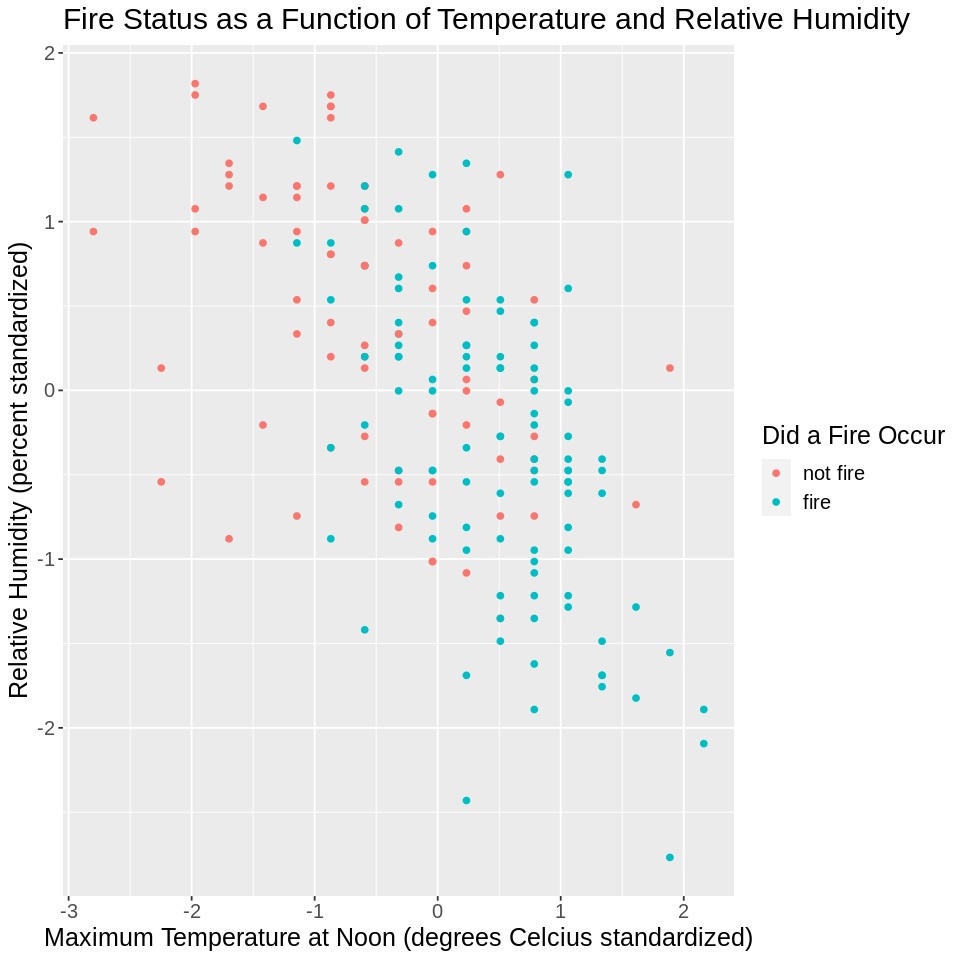

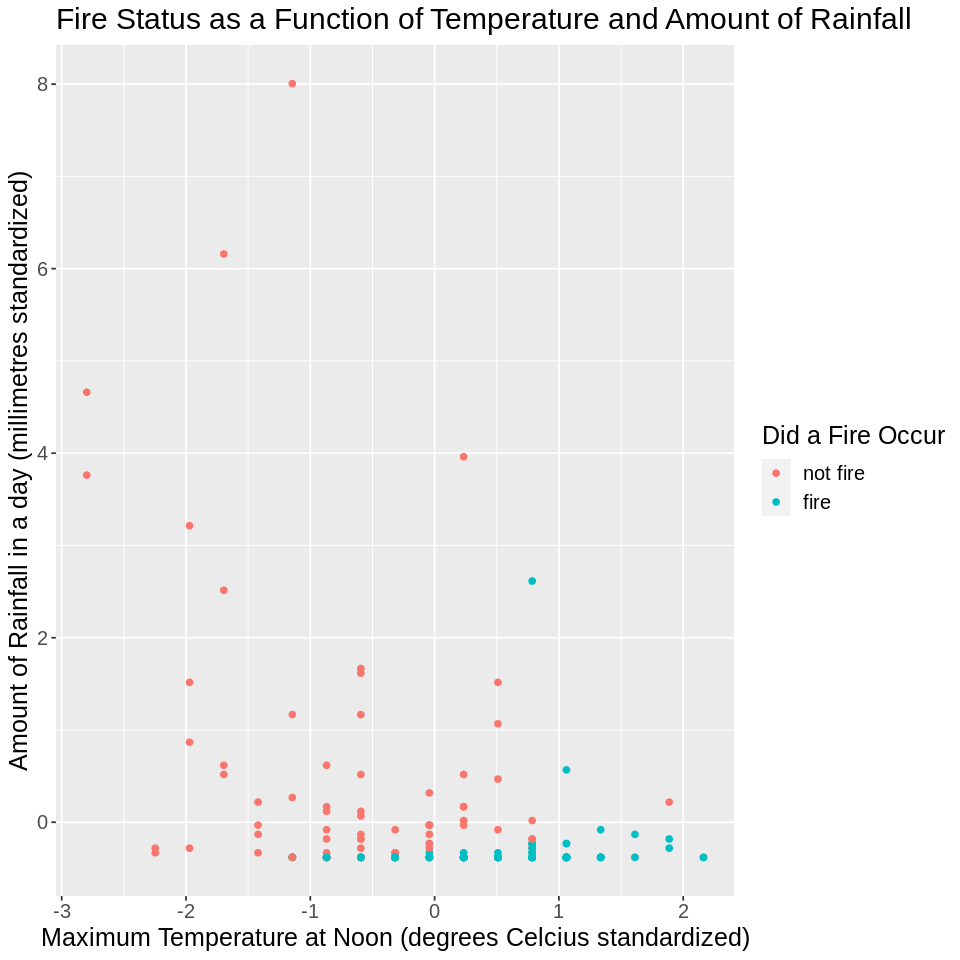

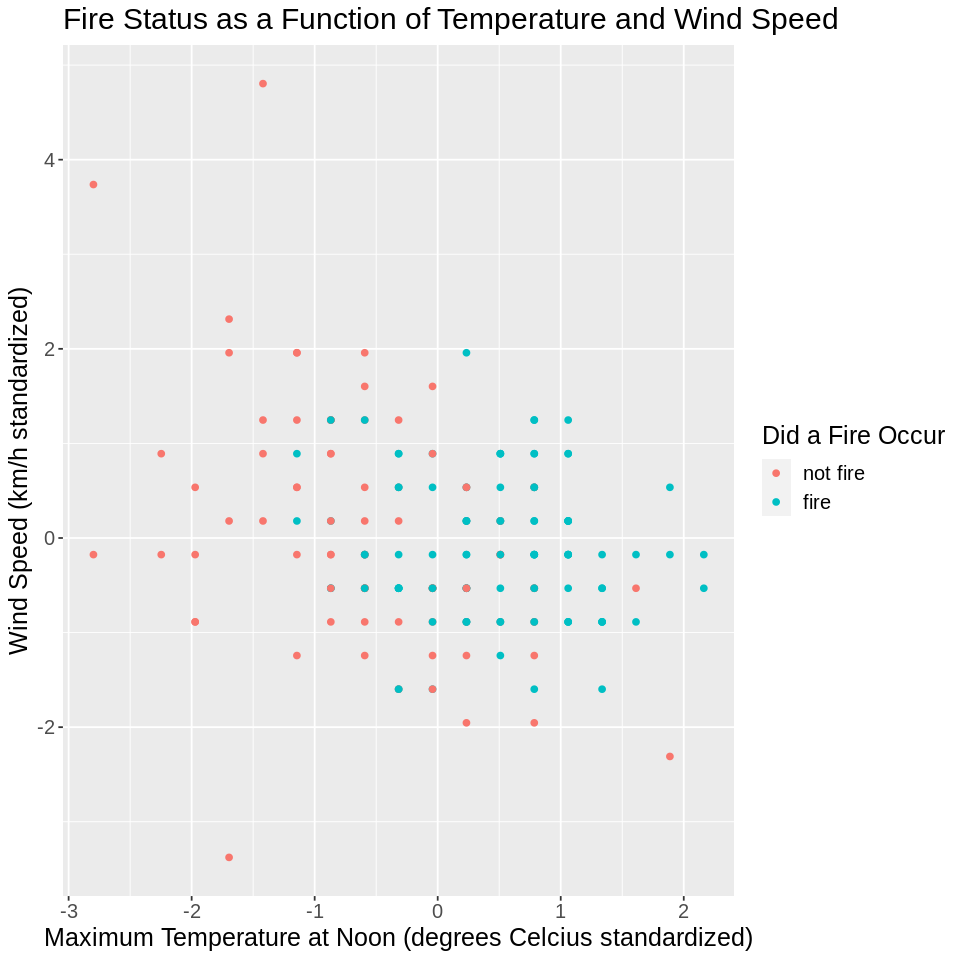

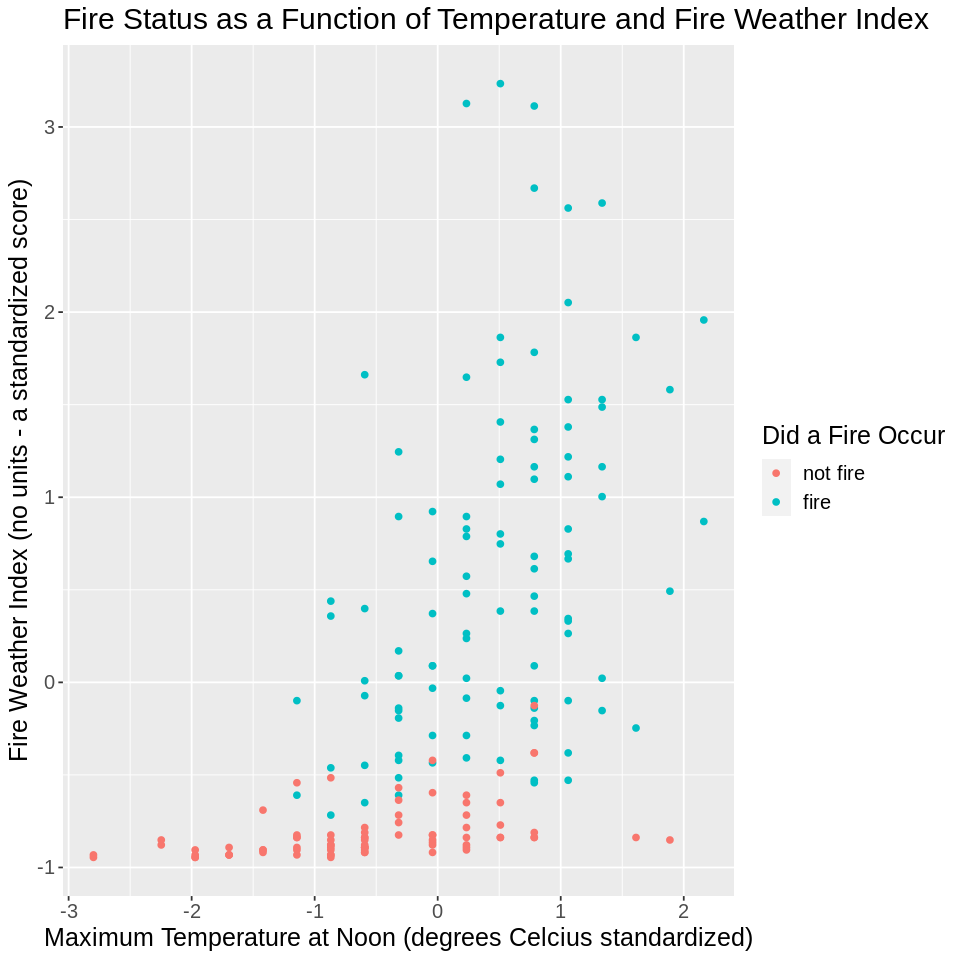

In [60]:
#Creating visualizations with the purpose of observing the types (including direction and strength) of relationships between our chosen predictors and fire occurence

options(repr.plot.width=8, repr.plot.height=8)
temperature_humidity_plot <- fire_train %>%
    ggplot(aes(x = scaled_Temperature, y = scaled_RH, colour = fire_occurrence)) +
geom_point() + 
labs(x = "Maximum Temperature at Noon (degrees Celcius standardized)",
     y = "Relative Humidity (percent standardized)",
    colour = "Did a Fire Occur") +
ggtitle("Fire Status as a Function of Temperature and Relative Humidity") +
  theme(text = element_text(size = 15))
temperature_humidity_plot

temperature_rain_plot <- fire_train %>%
    ggplot(aes(x = scaled_Temperature, y = scaled_Rain, colour = fire_occurrence))+
geom_point() +
labs(x = "Maximum Temperature at Noon (degrees Celcius standardized)",
     y = "Amount of Rainfall in a day (millimetres standardized)",
    colour = "Did a Fire Occur") +
ggtitle("Fire Status as a Function of Temperature and Amount of Rainfall") +
 theme(text = element_text(size = 15))
temperature_rain_plot

temperature_wind_plot <- fire_train %>%
    ggplot(aes(x = scaled_Temperature, y = scaled_Ws, colour = fire_occurrence))+
geom_point() +
labs(x = "Maximum Temperature at Noon (degrees Celcius standardized)",
     y = "Wind Speed (km/h standardized)",
    colour = "Did a Fire Occur") +
ggtitle("Fire Status as a Function of Temperature and Wind Speed") +
 theme(text = element_text(size = 15))
temperature_wind_plot

temperature_FWI_plot <- fire_train %>%
    ggplot(aes(x = scaled_Temperature, y = scaled_FWI, colour = fire_occurrence))+
geom_point() +
labs(x = "Maximum Temperature at Noon (degrees Celcius standardized)",
     y = "Fire Weather Index (no units - a standardized score)",
    colour = "Did a Fire Occur") +
ggtitle("Fire Status as a Function of Temperature and Fire Weather Index") +
 theme(text = element_text(size = 15))
temperature_FWI_plot

### Methods

We will use the K-nearest neighbors classification algorithm for our model in predicting forest fires. Based on our preliminary exploratory data analysis, we have identified the following variables as being related to the fire_occurrence column which indicates whether or not there is a fire: 
* Temperature (max temperature at noon in Celsius degrees)
* RH (relative humidity in %)
* Ws (wind speed in km/h)
* Rain (total precipitation per day in mm)
* FWI (Fire Weather Index rating of fire intensity from 0 to 31.1)	

We will use the training set to conduct a 5-fold cross-validation to help us find the best K-value for our classification algorithm. Using the identified K-value we will use our testing set to further train the algorithm. 

We will use a line plot to see which K-value has the highest average accuracy based on our 5-fold cross-validation. Additionally, we may use scatter plots to help us visualize a new point and its K-nearest values. Since we can only compare the new point against two variables while using a scatter plot, this step will mainly be used as a loose check for our classification algorithm. 

### Expected Outcomes and Significance

We expect to find: 
* A positive correlation between fire occurrence and temperature.
* A negative correlation between fire occurrence and: 
    * relative humidity
    * rain precipitation
*A very weak correlation (positive) between fire occurrence and wind speed 

What impact could such findings have?

* Significant in forest fire prevention by predicting fires before they start
    * This would allow areas to adequately prepare in time for a fire (e.g. evacuation, alerting appropriate rescue services)
    * Regions that lack data and/or technology to predict fires would especially benefit
    * Authorities can educate the population to avoid all fire triggers & decrease overall fire occurrences
    
What future questions could this lead to?

* With increasing global temperatures, what is the predicted percentage increase in forest fires in the next decade? 
* Will current forest fire fighting methods (e.g. chemical retardants) become ineffective as the intensity and scale of fires worsens due to climate change? 

### References

(1) Alexandrian, D., Esnault, F., & Calabri, G. (1998, October 30). Public policies affecting forest fires. _Forest Fires in the Mediterranean Area_. http://www.fao.org/3/x1880e/x1880e07.htm

(2) Meddour-Sahar, O. (2015). Wildfires in Algeria: Problems and challenges. _IForest - Biogeosciences and Forestry_, 8(6), 818–826. https://doi.org/10.3832/ifor1279-007